# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier
This project involves training a model to recognize traffic signs. The deep learning approach turned out to be really powerful, yielding a 96% test accuracy.

---
## Import Relevant Modules

In [1]:
import pickle
import os
import csv
import cv2
import skimage
import tensorflow as tf
tf.reset_default_graph()
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
from urllib.request import urlretrieve
import numpy as np
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
import matplotlib.pyplot as plt
from matplotlib import style

%matplotlib inline

print('All modules imported')

All modules imported


---
### Helper functions

`show_images` will be used to display an aribitrary number of images for exploratory purposes.

In [2]:
def show_images(images_arr, num_rows, num_cols, cmap=None, row_titles=[], image_titles=[]):
    num_images = len(images_arr)
    assert num_images != 0, "Number of images cannot be zero"
    assert num_images <= num_rows * num_cols, "Number of images cannot be > num_rows * num_cols"
    assert len(image_titles) == 0 or len(image_titles) == num_images, "Number of titles is incorrect"
    assert len(row_titles) == 0 or len(row_titles) == num_rows, "Number of row titles is incorrect"

    figwidth = 8 if num_cols <= 8 else num_cols
    figheight = num_rows * 1.75
    #fig = plt.figure(figsize=(figwidth,figheight), dpi=120)
    fig = plt.figure(figsize=(figwidth, figheight))
    axes = []
    if len(row_titles) > 0:
        mid_el_index = int(num_cols / 2)
        row_index = 0

    row_index = 0
    for i in range(num_images):
        temp = fig.add_subplot(num_rows, num_cols, i + 1)
        if len(image_titles) > 0:
            temp.set_title(image_titles[i])
        elif len(row_titles) > 0:
            if i % num_cols == mid_el_index:
                temp.set_title(row_titles[row_index])
                row_index += 1
        temp.axis('off')
        if cmap == 'gray':
            temp.imshow(images_arr[i].squeeze(), cmap='gray', interpolation='none')
        else:
            temp.imshow(images_arr[i], cmap=cmap, interpolation='none')
    plt.show()
    

---
## Download The Pickled Data

In [4]:
def download(url, file):
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download finished')
    else:
        print(file + ' retrieved from local storage.')

def unzip(file):
    with ZipFile(file) as zf:
        for f in zf.namelist():
            zf.extract(f)
            print(f + ' extracted.')
    
download('https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip', 'traffic-signs-data')

unzip('traffic-signs-data')

traffic-signs-data retrieved from local storage.
test.p extracted.
train.p extracted.
valid.p extracted.


---
## Load The Data

In [3]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_uint8, y_train = train['features'], train['labels']
X_valid_uint8, y_valid = valid['features'], valid['labels']
X_test_uint8, y_test = test['features'], test['labels']

In [4]:
X_train = (X_train_uint8 / 255.).astype('float32')
X_valid = (X_valid_uint8 / 255.).astype('float32')
X_test = (X_test_uint8 / 255.).astype('float32')

### Convert CSV file to a dictionary for exploration 

In [5]:
signs = {}
reader = csv.DictReader(open('signnames.csv'))
for row in reader:
    signs[int(row['ClassId'])] = row['SignName']

In [6]:
for k, v in signs.items():
    if k > 5 and k < 38:
        continue
    if k == 38:
        print("...")
    print(str(k) + ' : ' + v)

0 : Speed limit (20km/h)
1 : Speed limit (30km/h)
2 : Speed limit (50km/h)
3 : Speed limit (60km/h)
4 : Speed limit (70km/h)
5 : Speed limit (80km/h)
...
38 : Keep right
39 : Keep left
40 : Roundabout mandatory
41 : End of no passing
42 : End of no passing by vehicles over 3.5 metric tons


---

## Dataset Summary & Exploration

### Basic summary of the data set

In [7]:
n_train = X_train.shape[0]

n_validation = X_valid.shape[0]

n_test = X_test.shape[0]

image_shape = X_train.shape[1:]

n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


---
### Exploratory visualization of the dataset
In this section, I will first check the distributions of training, test, and validation data. After that I will print 5 random examples of each class and make observations.

### Distribution of Training, Test and Validation Data 

Max number of training samples is 2010.0 for Speed limit (50km/h)(2)
Min number of training samples is 180.0 for Speed limit (20km/h)(0)


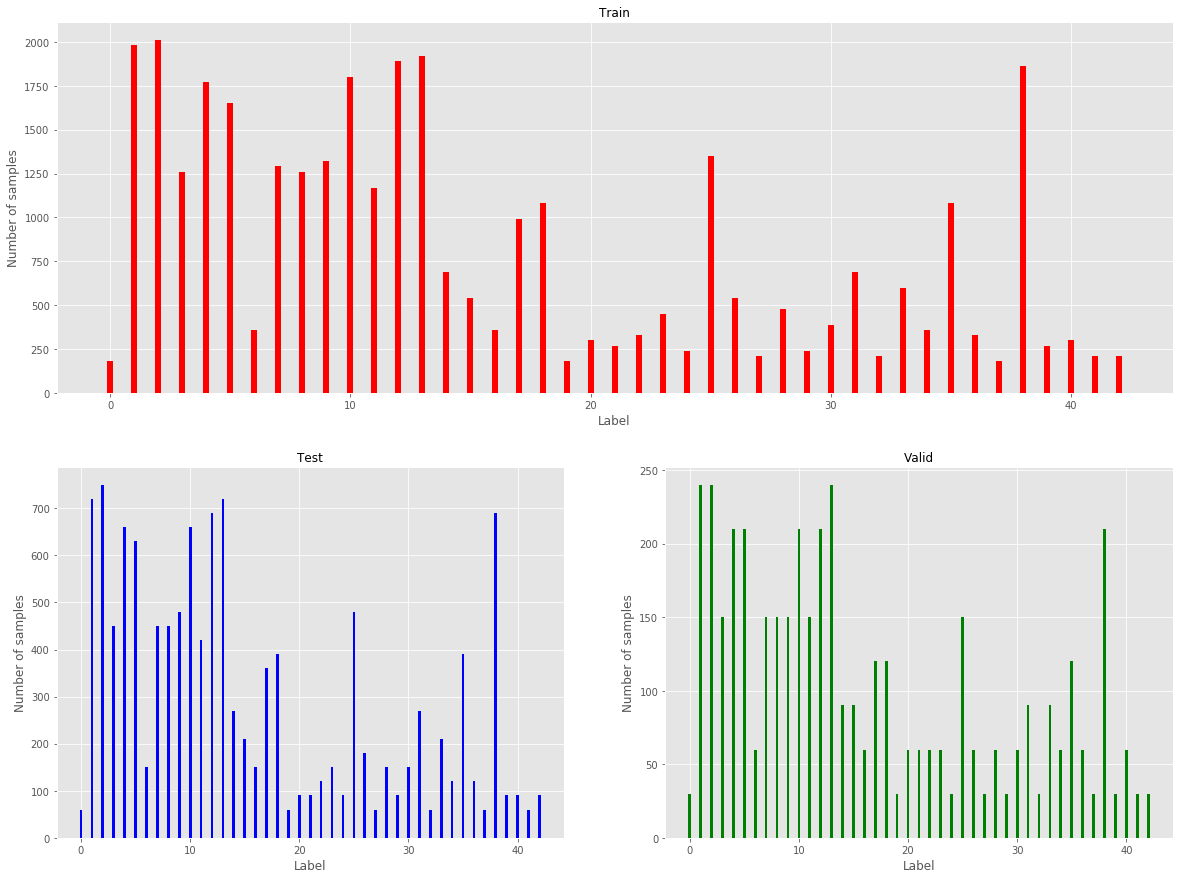

In [15]:
with style.context(('ggplot')):
    fig = plt.figure(figsize=(20,15))
    train_plot = plt.subplot2grid((2,2), (0,0), rowspan=1, colspan=2)
    test_plot = plt.subplot2grid((2,2), (1,0), rowspan=1, colspan=1)
    validation_plot = plt.subplot2grid((2,2), (1,1), rowspan=1,colspan=1)

n, _, _ = train_plot.hist(y_train, bins=np.arange(0,44,1), rwidth=0.25, align='left', label='Train', color='r')
print("Max number of training samples is {0} for {1}({2})".format(n.max(), signs[np.argmax(n)], np.argmax(n)))
print("Min number of training samples is {0} for {1}({2})".format(n.min(), signs[np.argmin(n)], np.argmin(n)))
train_plot.set_xlabel('Label')
train_plot.set_ylabel('Number of samples')
train_plot.set_title('Train')

test_plot.hist(y_test, bins=np.arange(0,44,1), rwidth=0.25, align='left', label='Test', color='b')
test_plot.set_xlabel('Label')
test_plot.set_ylabel('Number of samples')
test_plot.set_title('Test')

validation_plot.hist(y_valid, bins=np.arange(0,44,1), rwidth=0.25, align='left', label='Valid', color='g')
validation_plot.set_xlabel('Label')
validation_plot.set_ylabel('Number of samples')
validation_plot.set_title('Valid')

plt.show()

**Observations:**
1. The distribution of training, test and validation data is almost identical. That is good.
2. The distribution is **not** uniform as we would have wanted it ideally. Some classes have way more examples than others.

### Random samples of all 43 classes

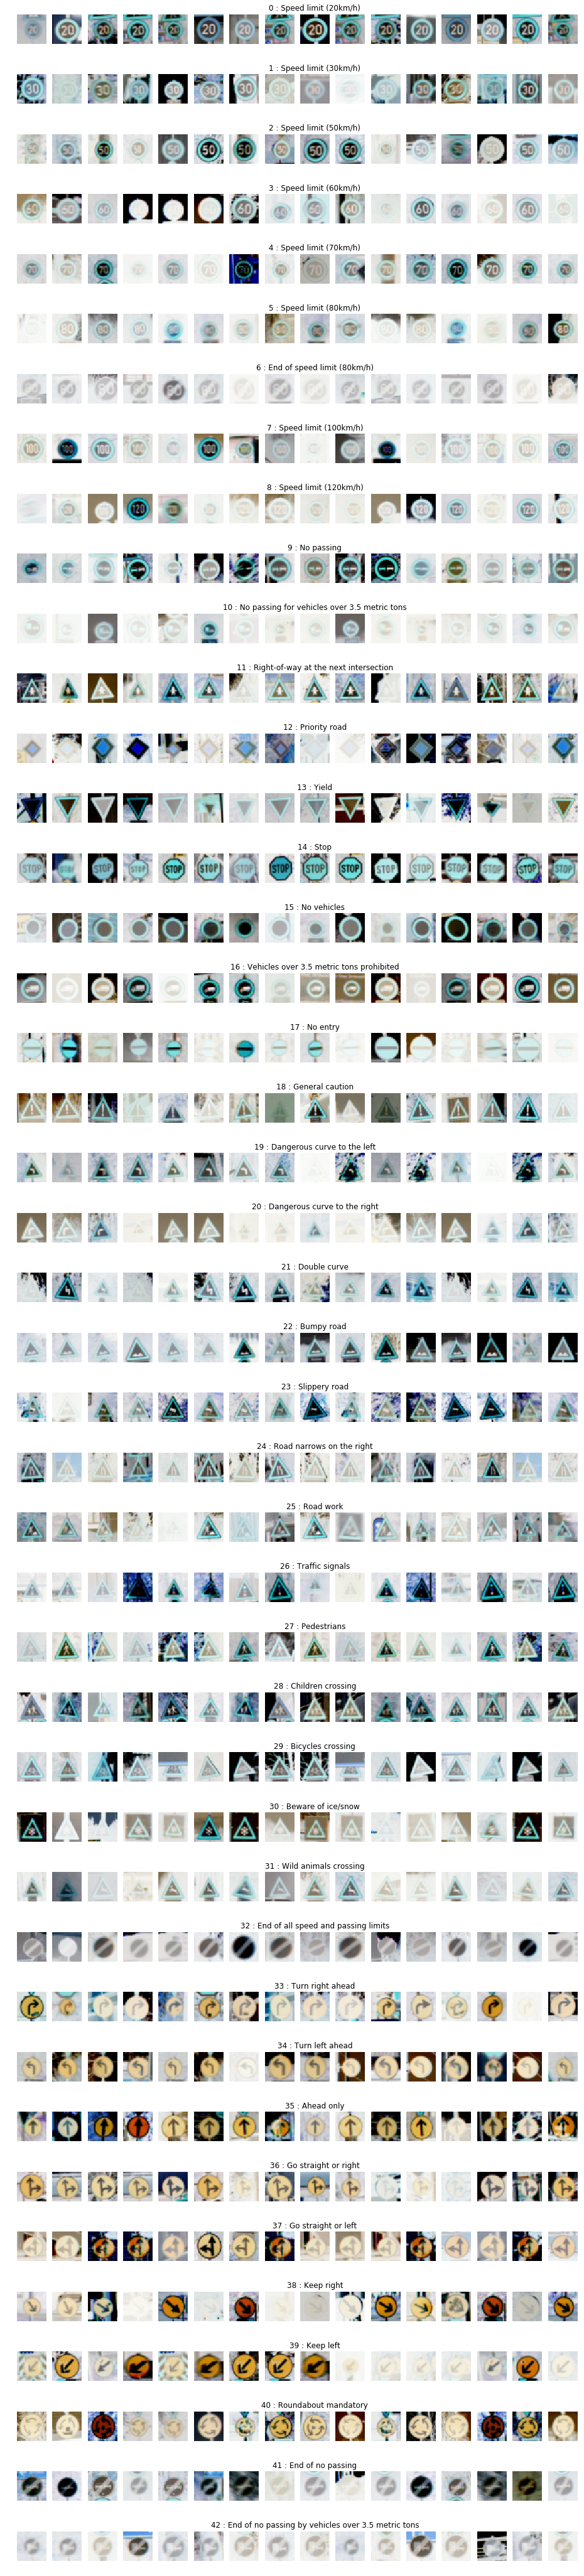

In [9]:
random_samples = np.empty([0,32,32,3])
num_rows = n_classes
indices_ = [i for i in range(43)]
row_titles = [str(i) + " : " + signs[i] for i in indices_]
for i in range(len(indices_)):
    indices = np.where(y_train == i)[0]
    np.random.shuffle(indices)
    indices = indices[:16]
    random_samples = np.concatenate((random_samples, X_train[indices]))
show_images(random_samples, num_rows, 16, row_titles=row_titles)
    

**Observation:**
Illumination variance. The contrast is very low for most of the images. We can enhance the contrast using a contrast enhancement technique. One of those techniques I'm going to use is histogram equalization.

### Vanilla Histogram Equalization
This technique is exactly what we need. We need to distribute the frequency of pixels to roughly all intensity values in our image. But there is a problem! Our images are in RGB color space, which doesn't have any notion of 'intensity'. The solution is to convert the image from RGB color space to YCrCb color space and perform histogram equalization on the 'Y' plane. In YCrCb color space, 'Y' means luminance which is the intensity metric, and Cr and Cb mean red-difference and blue-difference chroma components respectively.
From Wikipedia - 
>Histogram Equalization usually increases the global contrast of many images, especially when the usable data of the image is represented by close contrast values. Through this adjustment, the intensities can be better distributed on the histogram. This allows for areas of lower local contrast to gain a higher contrast. Histogram equalization accomplishes this by effectively spreading out the most frequent intensity values.

In [11]:
def histequalize_rgb(img):
    assert len(img.shape) == 3, "image has channels not equal to 3"
    ycrcb = convert_to_ycrcb(img)
    # Get the first channel only and hist equalize it
    channel_y = ycrcb[:,:,0]
    channel_y_equalized = cv2.equalizeHist(channel_y)
    ycrcb[:,:,0] = channel_y_equalized
    return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)

def adaptive_histequalize_rgb_images(images, clipLimit_=2.0, tileGridSize_=2):
    assert len(images.shape) == 4, "should be a batch of images"
    ret = np.empty_like(images)
    for i, img in enumerate(images):
        ret[i] = adaptive_histequalize_rgb(img)
    return ret

def adaptive_histequalize_rgb(img, clipLimit_=40.0, tileGridSize_=2):
    assert len(img.shape) == 3, "image has channels not equal to 3"
    clahe = cv2.createCLAHE(clipLimit=clipLimit_, tileGridSize=(tileGridSize_,tileGridSize_))
    ycrcb = convert_to_ycrcb(img)
    # Get the first channel only and hist equalize it
    channel_y = ycrcb[:,:,0]
    channel_y_equalized = clahe.apply(channel_y)
    ycrcb[:,:,0] = channel_y_equalized
    return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)

Let's apply histogram equalization to 16 random images of 5 random classes and print them. Note that the equalization happens in the `histequalize_rgb` method in the `Helper` class. The steps we take are:
1. Convert RGB to YCrCb color space. I tried applying the equalization directly by flattening the RGB channels, but got bad results. It is because RGB is not an 'intensity model'. Also, channel splitting and equalizing each channels doesn't work since histogram equalization is a non-linear process that is designed to operate on intensity values.

2. Equalize the 'Y' channel and leave 'Cr' and 'Cb' channels intact.

3. Merge the channels.

4. Convert the image from YcrCb to RGb and return it.

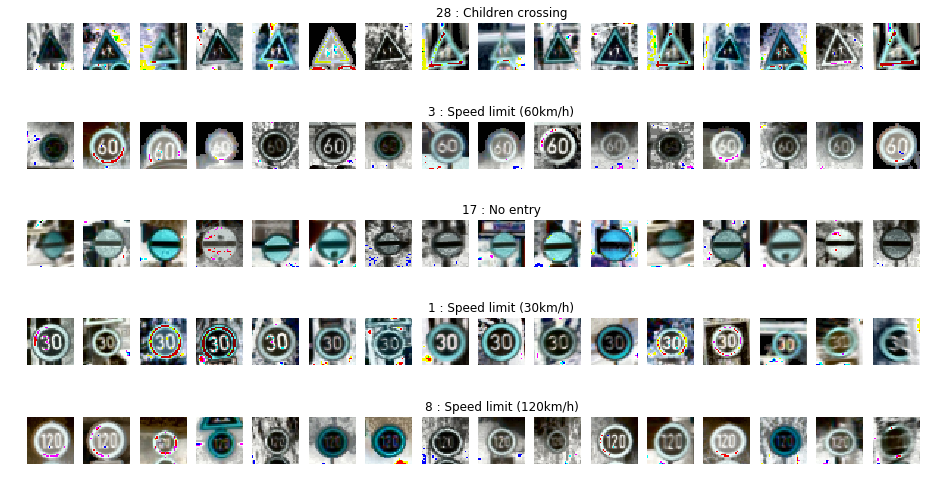

In [27]:
random_samples = np.empty([0,32,32,3])
indices_ = np.arange(43)
np.random.shuffle(indices_)
indices_ = indices_[:5]
row_titles = [str(i) + " : " + signs[i] for i in indices_.tolist()]
for i in indices_:
    indices = np.where(y_train == i)[0]
    np.random.shuffle(indices)
    indices = indices[:16]
    images = X_train[indices]
    for i in range(len(images)):
        images[i] = histequalize_rgb(images[i])
    random_samples = np.concatenate((random_samples, images))
show_images(random_samples, len(indices_), 16, row_titles=row_titles)

There is a notable improvement in the contrast of the images, but as we can see, there are a lot of rather unwanted artifacts in the image. We will now use another technique called *Contrast Limiting Adaptive Histogram Equalization* and see how it works.

From Wikipedia and OpenCV docs,
>Adaptive histogram equalization (AHE) is a computer image processing technique used to improve contrast in images. It differs from ordinary histogram equalization in the respect that the adaptive method computes several histograms, each corresponding to a distinct section of the image, and uses them to redistribute the lightness values of the image. It is therefore suitable for improving the local contrast and enhancing the definitions of edges in each region of an image. 

>However, if noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied.

### Contrast Limiting Adaptive Histogram Equalization

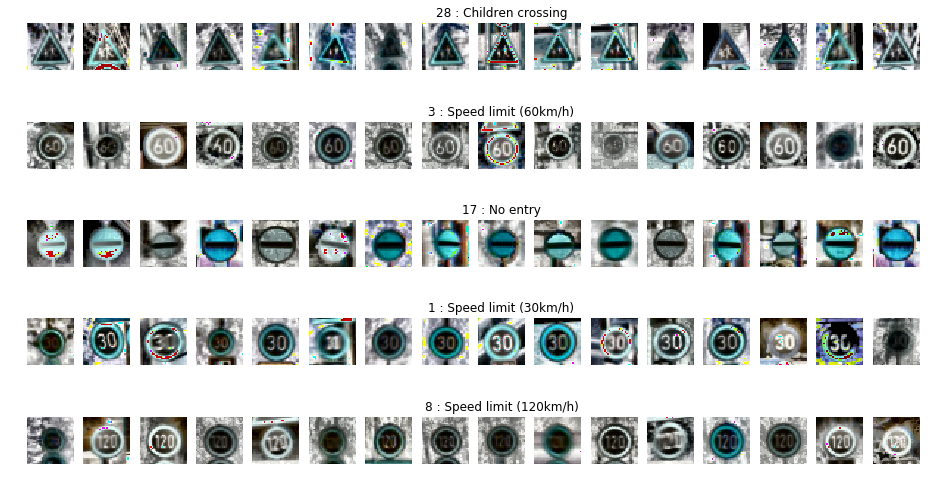

In [28]:
random_samples = np.empty([0,32,32,3])
for i in indices_:
    indices = np.where(y_train == i)[0]
    np.random.shuffle(indices)
    indices = indices[:16]
    images = X_train[indices]
    images = adaptive_histequalize_rgb_images(images)
    random_samples = np.concatenate((random_samples, images))
show_images(random_samples, len(indices_), 16, row_titles=row_titles)

This is much better, and the artifacts are much less severe, also to be attributed to the bilinear interpolation applied by `cv2`.

### One pipeline for preprocessing all images
My validation accuracy was higher when I didn't use the color, so this is a pipeline that converts all rgb images to YCrCb, performs local histogram equalization on the y channel, and returns it.

In [8]:
def preprocess_rgb_images(images, clipLimit_=2.0, tileGridSize_=4):
    """
    ---
    images: (n, width, height, channels)
    
    Return:
    (n, width, height, 1)
    """
    assert images.ndim == 4
    ret = np.zeros((images.shape[0], images.shape[1], images.shape[2], 1), dtype='float32')
    clahe = cv2.createCLAHE(clipLimit=clipLimit_, tileGridSize=(tileGridSize_,tileGridSize_))
    for i, img in enumerate(images):
        if img.shape[2] == 4:
            temp1 = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
            temp1 = cv2.cvtColor(temp1, cv2.COLOR_RGB2YCrCb)
        else:
            temp1 = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        channel_y = temp1[:,:,0]
        temp = (channel_y * 255).astype('uint8')
        ret[i] = ((clahe.apply(temp)[:,:,np.newaxis])/255.).astype('float32')
    assert ret.ndim == 4
    return ret

### Preprocess all images

In [13]:
X_train, y_train = shuffle(X_train, y_train)

In [14]:
X_train_normalized = preprocess_rgb_images(X_train)
X_test_normalized = preprocess_rgb_images(X_test)
X_valid_normalized = preprocess_rgb_images(X_valid)

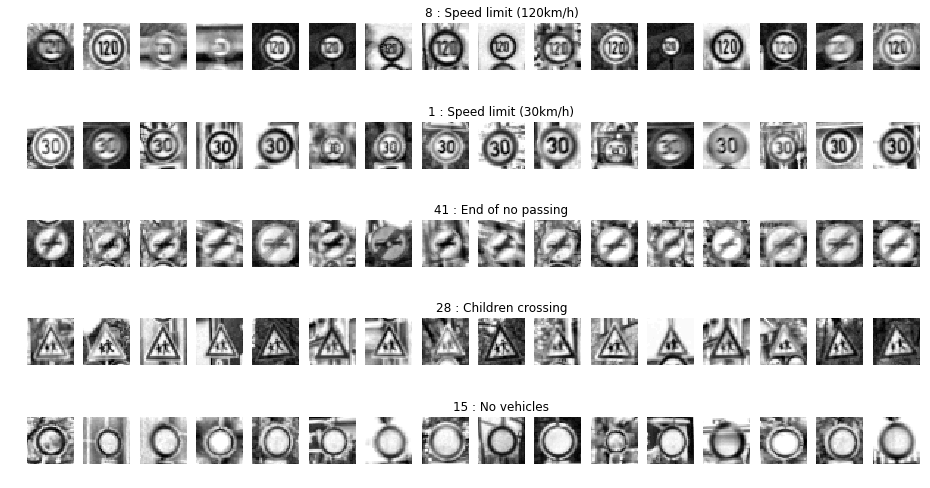

In [15]:
random_samples = np.empty([0,32,32,1])
indices_ = np.arange(43)
np.random.shuffle(indices_)
indices_ = indices_[:5]
row_titles = [str(i) + " : " + signs[i] for i in indices_.tolist()]
for i in indices_:
    indices = np.where(y_train == i)[0]
    np.random.shuffle(indices)
    indices = indices[:16]
    images = X_train[indices]
    random_samples = np.concatenate((random_samples, preprocess_rgb_images(images)))
show_images(random_samples, len(indices_), 16, cmap='gray', row_titles=row_titles)

This looks much better.

### Data augmentation
We found out that the distribution of the data is very uneven, so there are two ways we can address this situation:
1. Balance dataset to the mean.
2. Perform augmentation on the whole dataset. 


Since more data is never going to hurt, I decided to perform augmentations on the whole dataset. I perform 5 augmentations, described below:
1. Gaussian blur with sigma randomly selected between 0.25 and 1
2. X and Y scaling. Scale factor randomly chosen between 1.3 and 1.5
3. Rotation, random between -20 degrees and -5 degrees
4. Rotation, random between -5 degrees and -20 degrees
5. Shearing by a factor of 15

I also had experiemented with other augmentation methods like random cropping and affine translations, but did not get good results with them.

In [59]:
def get_augmented_dataset(x_, y_, numberOfAugmentations=5):
    assert numberOfAugmentations >= 0, "Number of augmentations cannot be less than zero"
    assert x_.ndim == 4, "Images need to be in batch (N, n_width, n_height, n_channels)"
    ret_x = np.copy(x_)
    ret_y = np.copy(y_)
    augmenters = np.array([
        iaa.GaussianBlur((0.25,1)),
        iaa.Affine(scale={"x": (1.3,1.5), "y": (1.3,1.5)}),
        iaa.Affine(rotate=(-20, -5)),
        iaa.Affine(rotate=(5,20)),
        iaa.Affine(shear=15),
        iaa.Affine(rotate=-15),
        iaa.Affine(translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)})
    ])
    
    for i in range(numberOfAugmentations):
        ret_x = np.concatenate((ret_x, augmenters[i].augment_images(x_)))
        ret_y = np.concatenate((ret_y, y_))
    return ret_x, ret_y

#### Example of data augmentation

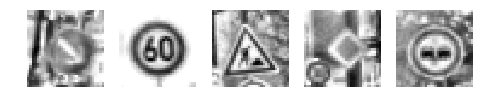

In [64]:
tt = np.copy(X_train_normalized[10:15])
tty = np.copy(y_train[10:15])
show_images(tt, 1,5,'gray')

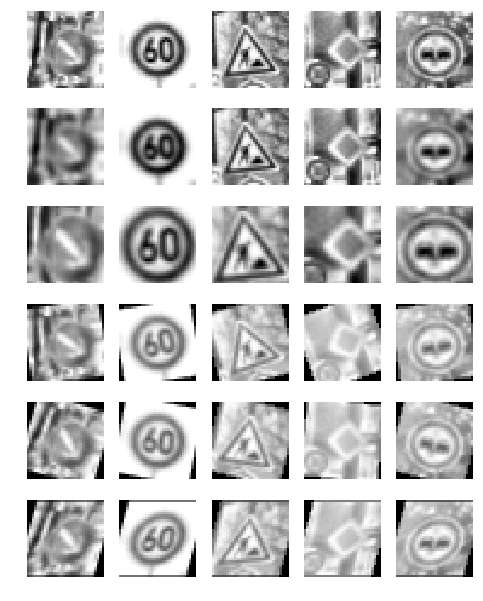

In [66]:
ttax, ttay = get_augmented_dataset(tt, tty, 5)
show_images(ttax, 6,5,'gray')

In [67]:
balanced_x, balanced_y = get_augmented_dataset(X_train_normalized, y_train, numberOfAugmentations=5)
balanced_x, balanced_y = shuffle(balanced_x, balanced_y)
print(balanced_x.shape)
print(balanced_y.shape)

(208794, 32, 32, 1)
(208794,)


In [68]:
print(str(balanced_x.shape[0] - X_train.shape[0]) + " new examples created. "\
      + str(int(balanced_x.shape[0]/X_train.shape[0]) - 1) + " times the original set.")

173995 new examples created. 5 times the original set.


----

## Step 2: Design and Test a Model Architecture


In [15]:
tf.reset_default_graph()

In [16]:
NUM_EPOCHS = 35
BATCH_SIZE = 128
LEARNING_RATE = 0.001

In [17]:
keep_prob_dnn = tf.placeholder(tf.float32, name='keep_prob_dnn')

In [18]:
weights = {
    'wc1': tf.get_variable("wc1", [5,5,1,6], initializer=tf.contrib.layers.xavier_initializer(seed=1)),
    'wc2': tf.get_variable("wc2", [5,5,6,16], initializer=tf.contrib.layers.xavier_initializer(seed=2)),
    'wf1':tf.get_variable("wf1", [400,120], initializer=tf.contrib.layers.xavier_initializer(seed=3)),
    'wf2': tf.get_variable("wf2", [120,84], initializer=tf.contrib.layers.xavier_initializer(seed=4)),
    'wf3': tf.get_variable("wf3", [84,64], initializer=tf.contrib.layers.xavier_initializer(seed=5)),
    'logits': tf.get_variable("wlogits", [84,43], initializer=tf.contrib.layers.xavier_initializer(seed=6))
}

biases = {
    'bc1': tf.get_variable("bc1", initializer=tf.zeros(6)),
    'bc2': tf.get_variable("bc2", initializer=tf.zeros(16)),
    'bf1': tf.get_variable("bf1", initializer=tf.zeros(120)),
    'bf2': tf.get_variable("bf2", initializer=tf.zeros(84)),
    'bf3': tf.get_variable("bf3", initializer=tf.zeros(64)),
    'logits': tf.get_variable("blogits", dtype=tf.float32, initializer=tf.zeros(43))
}

### Features and Labels

In [19]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Model Architecture

This is basically a LeNet architecture, but with one extra fully connected layer and dropout regularization.

In [20]:
def conv2d(x, f, b, strides=1, padding='VALID'):
    x = tf.nn.conv2d(x, f, [1,strides, strides, 1], padding)
    x = tf.nn.bias_add(x,b)
    return tf.nn.relu(x)

In [21]:
def maxpool2d(x, k, strides=None, padding='SAME'):
    if strides is None:
        strides = k
    return tf.nn.max_pool(x, [1,k,k,1], [1,k,k,1], padding)

In [22]:
def architecture(x, keep_prob_dnn):
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1, 2)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2, 2)
    
    # Flatten. Input = 5x5x16. Output = 400.
    flattened = tf.contrib.layers.flatten(conv2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.add(tf.matmul(flattened, weights['wf1']), biases['bf1'])
    fc1 = tf.nn.relu(fc1)
    # Apply dropout
    fc1 = tf.nn.dropout(fc1, keep_prob_dnn)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['wf2']), biases['bf2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob_dnn)
    
    # Layer 5: Fully Connected. Input = 84. Output = 64.
    fc3 = tf.add(tf.matmul(fc2, weights['wf3']), biases['bf3'])
    fc3 = tf.nn.relu(fc3)
    fc3 = tf.nn.dropout(fc3, keep_prob_dnn)

    # Layer 6: Fully Connected. Input = 64. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['logits']), biases['logits'])
    return logits

### Training Pipeline

In [23]:
logits = architecture(x, keep_prob_dnn)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation

In [24]:
correct_prediction = tf.equal(tf.argmax(logits, 1),\
                             tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_dnn: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [79]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(balanced_x)
    
    print("Training...")
    for i in range(NUM_EPOCHS):
        X_, y_ = shuffle(balanced_x, balanced_y)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_[offset:end], y_[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_dnn: 0.6})
            
        validation_accuracy = evaluate(X_valid_normalized, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './architecture')
    print("Model saved")

Training...
EPOCH 1 ...
Validation Accuracy = 0.893

EPOCH 2 ...
Validation Accuracy = 0.938

EPOCH 3 ...
Validation Accuracy = 0.947

EPOCH 4 ...
Validation Accuracy = 0.953

EPOCH 5 ...
Validation Accuracy = 0.955

EPOCH 6 ...
Validation Accuracy = 0.964

EPOCH 7 ...
Validation Accuracy = 0.967

EPOCH 8 ...
Validation Accuracy = 0.966

EPOCH 9 ...
Validation Accuracy = 0.970

EPOCH 10 ...
Validation Accuracy = 0.972

EPOCH 11 ...
Validation Accuracy = 0.972

EPOCH 12 ...
Validation Accuracy = 0.976

EPOCH 13 ...
Validation Accuracy = 0.973

EPOCH 14 ...
Validation Accuracy = 0.976

EPOCH 15 ...
Validation Accuracy = 0.974

EPOCH 16 ...
Validation Accuracy = 0.977

EPOCH 17 ...
Validation Accuracy = 0.976

EPOCH 18 ...
Validation Accuracy = 0.977

EPOCH 19 ...
Validation Accuracy = 0.978

EPOCH 20 ...
Validation Accuracy = 0.974

EPOCH 21 ...
Validation Accuracy = 0.976

EPOCH 22 ...
Validation Accuracy = 0.975

EPOCH 23 ...
Validation Accuracy = 0.976

EPOCH 24 ...
Validation Accurac

Max validation accuracy achieved : **98.2%**

Final validation accuracy: **97.8%**

### Test accuracy
This code has been run **only one time** after the model was developed to find the test accuracy.

In [83]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.960


That's it! Test accuracy of **96.0%**.
## HOORAY!!!

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

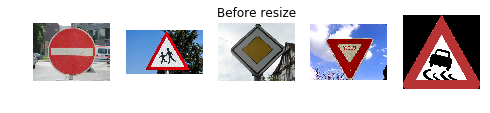

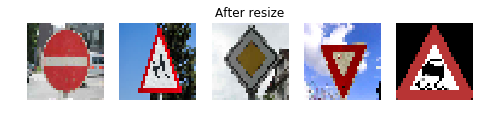

In [10]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from PIL import Image
import requests
urllist = ['http://bicyclegermany.com/Images/Laws/Do-Not-Enter.jpg',
          'https://cdn.pixabay.com/photo/2016/05/26/20/04/sign-1418256_960_720.jpg',
          'http://bicyclegermany.com/Images/Laws/Arterial.jpg',
          'https://c1.staticflickr.com/1/6/7036903_854a05945f_z.jpg',
          'https://cdn.pixabay.com/photo/2015/08/27/10/53/warning-910152_960_720.png']
images = np.empty((0,32,32,3), dtype='float32')
raw_images = []
for url in urllist:
    img = np.asarray(Image.open(requests.get(url, stream=True).raw))[:,:,0:3]
    raw_images.append(img)
    img = cv2.resize(img, (32,32))
    images = np.concatenate((images, img[np.newaxis,:,:,:]))

raw_images = np.array(raw_images)
show_images(raw_images, 1,5,row_titles=["Before resize"])
images /= 255.
show_images(images, 1,5, row_titles=["After resize"])

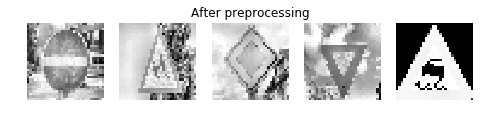

In [11]:
preprocessed_images = preprocess_rgb_images(images)
show_images(preprocessed_images, 1,5, 'gray', row_titles=["After preprocessing"])

### Predict the Sign Type for Each Image

In [172]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
def predict(image, model_name):
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph('./' + model_name + '.meta')
        saver.restore(sess, './' + model_name)
        prediction = tf.argmax(logits, 1)
        return prediction.eval(feed_dict={x: image[np.newaxis,:,:,:], keep_prob_dnn: 1.0})

Prediction: No entry


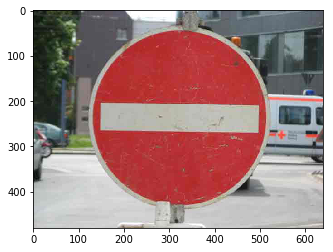

In [175]:
prediction = predict(preprocessed_images[0], 'architecture')
prediction = np.asscalar(prediction)
plt.imshow(raw_images[0])
print("Prediction: " + signs[prediction])

Bingo! 1 / 1 correct.

Prediction: Road narrows on the right


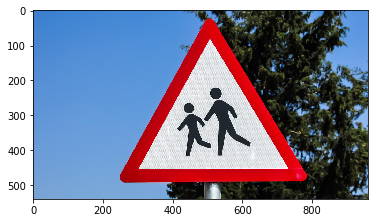

In [174]:
prediction = predict(preprocessed_images[1], 'architecture')
prediction = np.asscalar(prediction)
plt.imshow(raw_images[1])
print("Prediction: " + signs[prediction])

Oops! Was supposed to be 'Children crossing'. 1 / 2 correct.

Prediction: Priority road


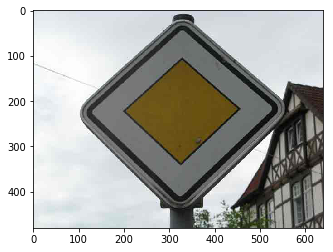

In [176]:
prediction = predict(preprocessed_images[2], 'architecture')
prediction = np.asscalar(prediction)
plt.imshow(raw_images[2])
print("Prediction: " + signs[prediction])

Nice! 2 / 3 correct.

Prediction: Yield


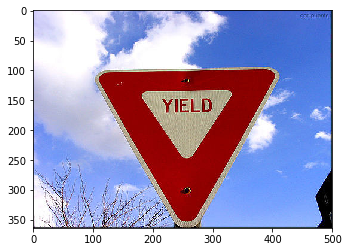

In [188]:
prediction = predict(preprocessed_images[3], 'architecture')
prediction = np.asscalar(prediction)
plt.imshow(raw_images[3])
print("Prediction: " + signs[prediction])

Nice again! 3 / 4 correct.

Prediction: Slippery road


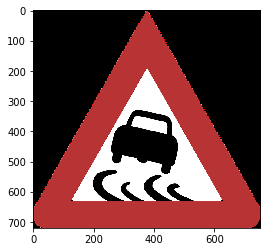

In [190]:
prediction = predict(preprocessed_images[4], 'architecture')
prediction = np.asscalar(prediction)
plt.imshow(raw_images[4])
print("Prediction: " + signs[prediction])

Spot on! 4 / 5 correct. This is 80% accurate on the new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [32]:
def get_top_k_softmax_probs(image, model_name, k):
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph('./' + model_name + '.meta')
        saver.restore(sess, './' + model_name)
        softmax = sess.run(tf.nn.softmax(logits), feed_dict={x:image[np.newaxis,:,:,:], keep_prob_dnn: 1.})
        return sess.run(tf.nn.top_k(softmax, k))

Best guesses in ascending order...
No entry : 99.999%
Turn left ahead : 0.001%
Stop : 0.001%
Keep right : 0.000%
Keep left : 0.000%


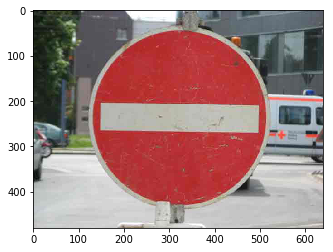

In [61]:
index = 0
plt.imshow(raw_images[index])
k_arr = get_top_k_softmax_probs(preprocessed_images[index], 'architecture', 5)
print("Best guesses in ascending order...")
for i in range(5):
    print("{} : {:.3f}%".format(signs[k_arr[1][0][i]], 100 * k_arr[0][0][i]))

Spot on! Never had doubts on this.

Best guesses in ascending order...
Road narrows on the right : 52.745%
Children crossing : 42.357%
Beware of ice/snow : 2.129%
Bicycles crossing : 0.748%
Pedestrians : 0.718%


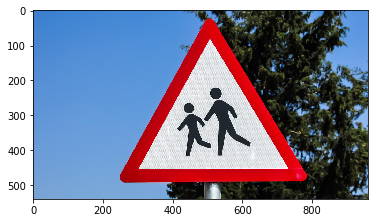

In [62]:
index = 1
plt.imshow(raw_images[index])
k_arr = get_top_k_softmax_probs(preprocessed_images[index], 'architecture', 5)
print("Best guesses in ascending order...")
for i in range(5):
    print("{} : {:.3f}%".format(signs[k_arr[1][0][i]], 100 * k_arr[0][0][i]))

---
This is the one that we got wrong, but it makes me happy that 'Children crossing' ranks second with 43.4% probability. Let's plot a random example of road narrows and see if these signs come close.

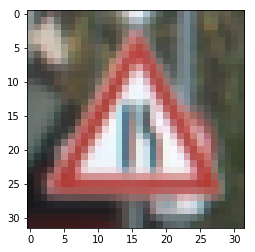

In [81]:
plt.imshow(X_train[np.where(y_train == 24)[0][np.random.randint(0,100)]])

These signs do look very similar, but at least the neural network got it 43.4% right.

---

Best guesses in ascending order...
Priority road : 99.999%
Yield : 0.001%
No passing : 0.000%
No vehicles : 0.000%
Speed limit (60km/h) : 0.000%


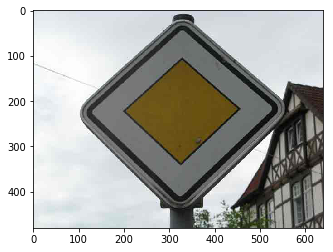

In [63]:
index = 2
plt.imshow(raw_images[index])
k_arr = get_top_k_softmax_probs(preprocessed_images[index], 'architecture', 5)
print("Best guesses in ascending order...")
for i in range(5):
    print("{} : {:.3f}%".format(signs[k_arr[1][0][i]], 100 * k_arr[0][0][i]))

Good 99% accuracy once again.

Best guesses in ascending order...
Yield : 100.000%
Priority road : 0.000%
Keep left : 0.000%
Ahead only : 0.000%
Keep right : 0.000%


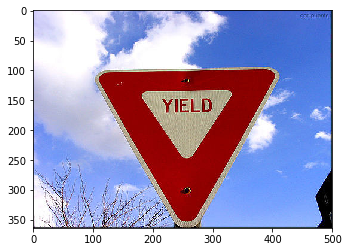

In [64]:
index = 3
plt.imshow(raw_images[index])
k_arr = get_top_k_softmax_probs(preprocessed_images[index], 'architecture', 5)
print("Best guesses in ascending order...")
for i in range(5):
    print("{} : {:.3f}%".format(signs[k_arr[1][0][i]], 100 * k_arr[0][0][i]))

This was a straight yield.

Best guesses in ascending order...
Slippery road : 99.998%
Wild animals crossing : 0.002%
Double curve : 0.000%
Beware of ice/snow : 0.000%
Right-of-way at the next intersection : 0.000%


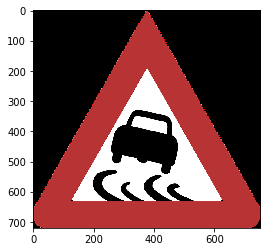

In [65]:
index = 4
plt.imshow(raw_images[index])
k_arr = get_top_k_softmax_probs(preprocessed_images[index], 'architecture', 5)
print("Best guesses in ascending order...")
for i in range(5):
    print("{} : {:.3f}%".format(signs[k_arr[1][0][i]], 100 * k_arr[0][0][i]))

No problems on this one either.

---
### Conclusion

This was a really great opportunity to learn about tensorflow and the empirical nature of making deep learning models. Possible improvements to this model include:
1. Hyperparameter tuning. I did not really experiment with a wide range of values for most hyperparameters. With enough computing power, I would love to take the Caviar approach and parallel train a lot of models instead of babysitting one model for a long time.

2. Different network architectures. I confined myself to tiny random variations of LeNet.

3. Remove the number of pooling layers and instead use dropout with keep_prob = ~0.9 in the convolutional layers for regularizing effect. 

4. Add batch normalization.

5. Even out the distribution of training data by careful augmentation.